In [1]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import pymoc
import glob
from time import sleep
import os


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo
import glob

import copy

In [2]:
def read_fits(filename):
    hdulist = fits.open(filename)
    data = hdulist[1].data
    hdulist.close()
    return(data)

In [3]:
def find_posteror_source(source_num,source_id):
    #finds the pkl file corresponding to the source you give.
    # Source_num: the row number of the source you want the pkl file for
    # Source_id: the sources id
    
    if type(source_num)==int:
        source_num = [source_num]
        source_id = [source_id]
    

    source_list = []
    for n,num in enumerate(source_num):
        file_num = int(num/10)
        #print(file_num)
        #print('data/fir_v2/xidplus_run_{}/lofar_xidplus_fir_{}_rerun.pkl.pkl'.format(file_num,file_num))
        name = file_list[file_num].replace('fits','pkl.pkl')
        #print(name)
        priors,posterior = xidplus.load(name)
        #print(source_id[n])
        if source_id[n] not in priors[0].ID:
            print('source number :{}: not in opened file. Something is wrong'.format(num))
        source_list.append([priors,posterior])
        
    return(source_list)

In [4]:
lofar_orig = Table.read('data/data_release/final_cross_match_catalogue-v0.1.fits')

In [5]:
file_list = glob.glob('data/fir_v2/*/*.fits')
file_array = np.array(file_list)

In [22]:
data_no_rerun = []
for i,file in enumerate(file_list):
    if 'rerun' in file:
        continue
    if i%100==0:
        print(i)
    with fits.open(file,memmap=False) as hdul:
        for n,hdu in enumerate(hdul):
            if n==1:
                data = hdu.data
                data_no_rerun.append(copy.deepcopy(data))
                del data
                del hdu

0
100
300
600
700
800
900
1100
1200
1300
1400
1500
1700
1900
2100
2200
2300
2400
2500
2600
2700
2800
2900
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4600
4700
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6700
6800
6900
7000
7100
7200
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8700
8900
9000
9100
9200
9300
9400
9500
9700
9800
9900
10000
10100
10300
10400
10500
10600
10700
10800
10900
11000
11200
11300
11400
11500
11600
11700
11800
11900
12100
12200
12300
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13600
13900
14000
14100
14200
14300
14500
14600
14800
15000
15100
15200
15400
15500
15600
15700
15900
16000
16100
16200
16400
16500
16600
16700
16900
17100
17200
17300
17400
17600
17700
17900
18000
18100
18200
18300
18500
18600
18800
18900
19000
19100
19200
19300
19500
19600
19700
19800
20200
20300
20500
20600
20700
20800
20900
21200
21500
21600
21700
21800
21900
22000
22300
22400
22600
22700
22800
2

In [ ]:
#data_no_rerun = [read_fits(file) for i,file in enumerate(file_list) if 'rerun' not in file]

In [23]:
colnames = Table.read('data/fir_v2/xidplus_run_4/lofar_xidplus_fir_4.fits').colnames

In [24]:
colnames

['Source_id',
 'Isl_id',
 'RA',
 'E_RA',
 'DEC',
 'E_DEC',
 'Total_flux',
 'E_Total_flux',
 'Peak_flux',
 'E_Peak_flux',
 'RA_max',
 'E_RA_max',
 'DEC_max',
 'E_DEC_max',
 'Maj',
 'E_Maj',
 'Min',
 'E_Min',
 'PA',
 'E_PA',
 'Maj_img_plane',
 'E_Maj_img_plane',
 'Min_img_plane',
 'E_Min_img_plane',
 'PA_img_plane',
 'E_PA_img_plane',
 'DC_Maj',
 'E_DC_Maj',
 'DC_Min',
 'E_DC_Min',
 'DC_PA',
 'E_DC_PA',
 'DC_Maj_img_plane',
 'E_DC_Maj_img_plane',
 'DC_Min_img_plane',
 'E_DC_Min_img_plane',
 'DC_PA_img_plane',
 'E_DC_PA_img_plane',
 'Isl_Total_flux',
 'E_Isl_Total_flux',
 'Isl_rms',
 'Isl_mean',
 'Resid_Isl_rms',
 'Resid_Isl_mean',
 'S_Code',
 'FLAG_OVERLAP_1',
 'lr_fin',
 'lr_dist_fin',
 'lr_index_fin',
 'fworkflow_all',
 'FLAG_WORKFLOW',
 'NUMBER',
 'SNR_WIN',
 'BACKGROUND',
 'THRESHOLD',
 'X_IMAGE',
 'Y_IMAGE',
 'ra_1',
 'dec_1',
 'X2_IMAGE',
 'Y2_IMAGE',
 'XY_IMAGE',
 'X2_WORLD',
 'Y2_WORLD',
 'A_IMAGE',
 'B_IMAGE',
 'THETA_IMAGE',
 'ERRA_IMAGE',
 'ERRB_IMAGE',
 'ERRTHETA_IMAGE',
 'FL

In [25]:
colnames_use = ['Source_id',
 'Isl_id',
 'RA_1',
 'E_RA',
 'DEC',
 'E_DEC',
 'ra_2',
 'dec_2',
 'f_spire_250',
 'ferr_spire_250',
 'flag_spire_250',
 'f_spire_350',
 'ferr_spire_350',
 'flag_spire_350',
 'f_spire_500',
 'ferr_spire_500',
 'flag_spire_500',
 'flag_optnir_det',
 'f_mips_24',
 'XID_rerun',
 'source_type']

In [26]:
data_no_rerun_list = [data_no_rerun[i][name] for name in colnames_use for i in range(len(data_no_rerun))] 

In [27]:
data_no_rerun_table_use = np.array(data_no_rerun_list).reshape(int(len(data_no_rerun_list)/len(data_no_rerun)),len(data_no_rerun))
data_no_rerun_table_use = [data_no_rerun_table_use[i] for i in range(len(data_no_rerun_table_use))]

In [28]:
data_no_rerun_table = Table(data=data_no_rerun_table_use,names=colnames_use)

In [29]:
mask = data_no_rerun_table['flag_spire_250'] == 'True'
data_no_rerun_table['flag_spire_250'][mask] = 1
data_no_rerun_table['flag_spire_250'][~mask] = 0
mask = data_no_rerun_table['flag_spire_350'] == 'True'
data_no_rerun_table['flag_spire_350'][mask] = 1
data_no_rerun_table['flag_spire_350'][~mask] = 0
mask = data_no_rerun_table['flag_spire_500'] == 'True'
data_no_rerun_table['flag_spire_500'][mask] = 1
data_no_rerun_table['flag_spire_500'][~mask] = 0

In [30]:
for name in colnames_use:
    print(name)
    if 'id' in name:
        data_no_rerun_table[name] = data_no_rerun_table[name].astype(int)
        continue
        
    if 'optnir' in name:
        data_no_rerun_table[name] = data_no_rerun_table[name].astype(int)
        continue
        
    if'flag' in name:
        data_no_rerun_table[name] = data_no_rerun_table[name].astype(bool)
        continue

    if 'rerun'in name:
        continue
    if 'type' in name:
        continue
    data_no_rerun_table[name] = data_no_rerun_table[name].astype(float)

Source_id
Isl_id
RA_1
E_RA
DEC
E_DEC
ra_2
dec_2
f_spire_250
ferr_spire_250
flag_spire_250
f_spire_350
ferr_spire_350
flag_spire_350
f_spire_500
ferr_spire_500
flag_spire_500
flag_optnir_det
f_mips_24
XID_rerun
source_type


In [31]:
data_no_rerun_table.rename_column('RA_1','RA_radio')
data_no_rerun_table.rename_column('DEC','DEC_radio')
data_no_rerun_table.rename_column('ra_2','RA_optical')
data_no_rerun_table.rename_column('dec_2','DEC_optical')

In [32]:
data_no_rerun_table[:5]

Source_id,Isl_id,RA_radio,E_RA,DEC_radio,E_DEC,RA_optical,DEC_optical,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,flag_optnir_det,f_mips_24,XID_rerun,source_type
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,bool,float64,float64,bool,int64,float64,str32,str32
11188,11221,245.56578560168245,0.0002471000402460799,54.917808438453065,0.00015312112180382957,245.56576090298938,54.91902658232867,11019.371,3092.141599999999,False,21895.573,3110.4029999999984,False,25246.68,1562.828999999998,False,6,59.862274,False,nearest_prior
11202,11235,245.55483895031202,6.270472852990592e-05,54.789896398364675,7.199854063865182e-05,245.55486235239024,54.79001147528079,30274.975000000002,3193.3849999999984,False,29705.154,4812.888999999999,False,26555.77,6240.956000000002,False,6,565.82947,False,nearest_prior
11154,11187,245.57614522759943,0.00024286511052720277,54.9622791035095,8.600107292059286e-05,245.5760261331011,54.96229947940713,5889.168299999999,2841.824700000001,False,6727.674,2850.8250000000016,False,4596.262000000001,3435.996,False,6,111.98047,False,nearest_prior
11315,11348,245.56004178965807,0.00012082939411326408,55.11191624362935,5.771946443312041e-05,245.56007702405702,55.1128389434993,66076.36,12254.303999999996,True,23747.787,13287.552,True,10736.1,9404.884,False,7,1744.0573,False,nearest_prior
11264,11297,245.5443103895625,8.502838465312147e-05,54.77578769888053,8.329357661041251e-05,245.544328090057,54.7759088114993,22578.224,3092.274999999998,False,6551.7716,4251.2374,False,9051.606,7043.939000000002,False,7,487.0581,False,nearest_prior


In [77]:
len(file_list)

429

In [78]:
test = Table.read('data/fir_v2/xidplus_run_0/lofar_xidplus_fir_0_rerun.fits')

In [79]:
test

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
ILTJ155958.68+550534.6,239.9942929896559,55.0930282279941,17.664255,21.974651,11.189934,10.243038,14.578951,4.8552785,5.4062552,10.983551,1.62666,-3.6571808,-6.0297723,-10.962864,1.7041748,2.358391,3.2390459,1.0020123,0.99952734,0.9997526,1050.6903,2229.5396,1448.9312,0.0,0.003,0.0
ILTJ160000.65+550723.3,240.00272394467896,55.12321259192885,4.5300894,9.263515,1.3774209,5.2070374,11.266669,1.4554693,3.6987534,8.900294,0.9842537,-3.6571808,-6.0297723,-10.962864,1.7041748,2.358391,3.2390459,1.0031277,1.0010837,0.99984723,1640.3042,2686.055,1730.3901,0.0,0.0,0.001
ILTJ160004.97+550437.9,240.021329,55.077283,20.662958,34.080826,6.1200237,21.272715,35.973362,6.703374,13.4880905,22.775002,4.5852623,-3.6571808,-6.0297723,-10.962864,1.7041748,2.358391,3.2390459,0.99894804,0.99839455,0.9988604,1966.0131,1899.4594,2169.3088,0.001,0.0,0.0
ILTJ160005.65+550103.6,240.023738,55.017746,4.287435,7.58809,1.4510972,1.1595327,2.6527047,0.30823848,1.990985,4.5711703,0.4929302,-3.6571808,-6.0297723,-10.962864,1.7041748,2.358391,3.2390459,1.0020199,0.9993429,0.9982081,2341.1572,2633.129,2923.8057,0.0,0.0,0.0
ILTJ160005.72+544939.4,240.02382016062427,54.82762971242221,4.2068434,7.3078547,1.6642306,4.4987545,7.6510053,1.797905,9.064219,14.670753,3.9907224,-3.6571808,-6.0297723,-10.962864,1.7041748,2.358391,3.2390459,0.9998088,0.99933326,0.9992015,1755.218,2063.553,1998.0112,0.0,0.0,0.001
ILTJ160006.05+545406.7,240.02516896110987,54.901592240930476,4.839427,9.31622,1.5560771,2.7200882,6.1780376,0.76490694,3.5758445,8.327212,1.0068605,-3.6571808,-6.0297723,-10.962864,1.7041748,2.358391,3.2390459,0.9998639,0.9991178,0.99923146,2363.3406,2797.2727,2455.841,0.0,0.0,0.0
ILTJ160006.73+544333.5,240.02756867520733,54.72560449940974,4.5781775,9.213495,1.532103,7.1688876,12.21115,2.7457974,2.8437438,6.2367935,0.79136676,-3.6571808,-6.0297723,-10.962864,1.7041748,2.358391,3.2390459,1.0003859,1.0010926,0.99870217,1694.166,3040.9778,1684.861,0.0,0.0,0.004
ILTJ160006.74+550651.5,240.02846707033066,55.114534864995065,16.08227,18.660604,13.511759,17.673082,20.550083,14.701836,5.4927416,9.7372,1.9267374,-3.6571808,-6.0297723,-10.962864,1.7041748,2.358391,3.2390459,0.9987448,0.9986842,1.0002539,3752.1746,2138.9622,3672.5598,0.0,0.0,0.0


In [83]:
file_list = glob.glob('data/fir_v2/*/lofar_xidplus_fir*.fits')
num_not = np.arange(428,860,1)

lofar_fir_table = Table.read(file_list[0])
for i,filename in enumerate(file_list[1:]):
    #print(filename)
    if i%50==0:
        print(i)
    
    run_num = 0
    try:
        run_num = int(filename[24:27])
    except:
        run_num = 0
    #print(run_num)
    if run_num>428:
        continue
    
    #print(filename)
    new_table = Table.read(filename,memmap=False)
    if len(new_table)!=20:
        print(filename)
        print('length of table is: {}'.format(len(new_table)))
    lofar_fir_table = vstack([lofar_fir_table,new_table])
    

0
50
100
150
200
250
300
350
data/fir_v2/xidplus_run_428/lofar_xidplus_fir_428_rerun.fits
length of table is: 8
400


In [84]:
data_rerun_table = lofar_fir_table

In [85]:
data_rerun_table

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
ILTJ160624.60+535251.5,241.6028781240088,53.881066302889344,8.032131,10.086995,5.794605,5.241268,8.237766,2.3429983,3.4749465,7.3106446,1.0511472,-5.1749587,-8.751494,-14.994785,1.7582943,1.9608303,2.5456598,1.0005233,1.0003403,0.998883,1090.187,2130.0012,1544.2251,0.0,0.001,0.002
ILTJ160624.70+534055.2,241.6019104233721,53.68195738666406,5.4468484,10.251058,1.7387465,4.3064504,7.9708996,1.3895764,2.8207808,6.0968666,0.8188015,-5.1749587,-8.751494,-14.994785,1.7582943,1.9608303,2.5456598,1.00388,1.0005496,1.0004444,1507.085,2580.922,1632.7332,0.009,0.01,0.001
ILTJ160624.73+540249.2,241.60303137130026,54.04700069290669,2.2194872,3.8325434,0.9053043,3.462483,5.9867783,1.2984395,5.954709,10.231757,2.3074274,-5.1749587,-8.751494,-14.994785,1.7582943,1.9608303,2.5456598,1.0001415,1.0013274,0.9993085,1980.2239,1693.0586,1605.3209,0.001,0.007,0.001
ILTJ160624.79+553229.3,241.60367390548646,55.541521971433596,5.532169,10.582454,1.6626897,2.966647,7.304661,0.7200797,1.8306099,4.63507,0.440102,-5.1749587,-8.751494,-14.994785,1.7582943,1.9608303,2.5456598,1.0010041,0.9996238,0.9992998,2231.4556,2586.6458,2357.4158,0.0,0.0,0.0
ILTJ160624.91+542255.5,241.60505538767393,54.38198212082139,3.4847825,7.7751985,0.9294674,1.8653065,4.594617,0.44854498,2.010978,4.7890925,0.57275575,-5.1749587,-8.751494,-14.994785,1.7582943,1.9608303,2.5456598,0.99969256,1.0003594,0.9993917,1446.3425,2355.3015,1504.8899,0.0,0.005,0.021
ILTJ160624.94+561057.9,241.60432990604832,56.182886416530984,5.044669,9.614662,1.5685811,8.339525,14.902276,2.5404227,4.5789304,9.830851,1.3468839,-5.1749587,-8.751494,-14.994785,1.7582943,1.9608303,2.5456598,1.0033472,1.0014212,1.0007454,1579.9825,2319.157,2230.756,0.0,0.0,0.0
ILTJ160625.07+534159.2,241.6044783338865,53.69977954493742,26.291119,30.328539,21.836021,16.823198,20.176544,12.183946,4.781195,8.682158,1.4588428,-5.1749587,-8.751494,-14.994785,1.7582943,1.9608303,2.5456598,1.0001506,1.0010945,1.0016109,1443.646,1874.1912,1365.0692,0.0,0.001,0.067
ILTJ160625.25+540310.2,241.6051851241524,54.052957339010845,4.062256,7.719266,1.332092,3.0152884,6.577731,0.83650076,2.6567428,5.9208846,0.67535317,-5.1749587,-8.751494,-14.994785,1.7582943,1.9608303,2.5456598,1.0016501,0.99920666,0.9999504,1554.0283,2744.1687,2376.3762,0.0,0.0,0.002


In [66]:
len(file_list)

429

In [26]:
data_rerun = []
for i,file in enumerate(file_list):
    if 'rerun' not in file:
        continue
    if '.pkl' in file:
        continue
    if i%100==0:
        print(i)
    with fits.open(file,memmap=False) as hdul:
        for n,hdu in enumerate(hdul):
            if n==1:
                data = hdu.data
                data_rerun.append(copy.deepcopy(data))
                del data
                del hdu

0
300
400
600
800
1000
1100
1600
1700


In [38]:
data_rerun = [fits.open(file)[1].data for i,file in enumerate(file_list) if '.fits' in file]

In [40]:
len(data_rerun)

857

In [29]:
colnames = Table.read('data/fir_v2/xidplus_run_5/lofar_xidplus_fir_5_rerun.fits').colnames

In [30]:
colnames

['HELP_ID',
 'RA',
 'Dec',
 'F_SPIRE_250',
 'FErr_SPIRE_250_u',
 'FErr_SPIRE_250_l',
 'F_SPIRE_350',
 'FErr_SPIRE_350_u',
 'FErr_SPIRE_350_l',
 'F_SPIRE_500',
 'FErr_SPIRE_500_u',
 'FErr_SPIRE_500_l',
 'Bkg_SPIRE_250',
 'Bkg_SPIRE_350',
 'Bkg_SPIRE_500',
 'Sig_conf_SPIRE_250',
 'Sig_conf_SPIRE_350',
 'Sig_conf_SPIRE_500',
 'Rhat_SPIRE_250',
 'Rhat_SPIRE_350',
 'Rhat_SPIRE_500',
 'n_eff_SPIRE_250',
 'n_eff_SPIRE_500',
 'n_eff_SPIRE_350',
 'Pval_res_250',
 'Pval_res_350',
 'Pval_res_500']

In [261]:
colnames_use = ['HELP_ID',
 'RA',
 'Dec',
 'F_SPIRE_250',
 'FErr_SPIRE_250_u',
 'FErr_SPIRE_250_l',
 'F_SPIRE_350',
 'FErr_SPIRE_350_u',
 'FErr_SPIRE_350_l',
 'F_SPIRE_500',
 'FErr_SPIRE_500_u',
 'FErr_SPIRE_500_l',
 'Bkg_SPIRE_250',
 'Bkg_SPIRE_350',
 'Bkg_SPIRE_500',
 'Sig_conf_SPIRE_250',
 'Sig_conf_SPIRE_350',
 'Sig_conf_SPIRE_500',
 'Rhat_SPIRE_250',
 'Rhat_SPIRE_350',
 'Rhat_SPIRE_500',
 'n_eff_SPIRE_250',
 'n_eff_SPIRE_500',
 'n_eff_SPIRE_350',
 'Pval_res_250',
 'Pval_res_350',
 'Pval_res_500']

In [262]:
data_rerun_list = [data_rerun[i][name] for name in colnames_use for i in range(len(data_rerun))] 

In [263]:
len(colnames_use)

27

In [264]:
data_table_use = np.array(data_rerun_list).reshape(int(len(data_rerun_list)/len(data_rerun)),len(data_rerun))
data_table_use = [data_table_use[i] for i in range(len(data_table_use))]

In [265]:
data_rerun_table = Table(data=data_table_use,names=colnames_use)

In [48]:
for name in colnames_use:
    print(name)
    if 'id' in name:
        data_rerun_table[name] = data_rerun_table[name].astype(int)
        continue
        
    if 'optnir' in name:
        data_rerun_table[name] = data_rerun_table[name].astype(int)
        continue

    if 'rerun'in name:
        continue
    if 'type' in name:
        continue
    data_rerun_table[name] = data_rerun_table[name].astype(float)

HELP_ID


ValueError: setting an array element with a sequence.

In [95]:
data_rerun_table.colnames

['HELP_ID',
 'RA',
 'Dec',
 'F_SPIRE_250',
 'FErr_SPIRE_250_u',
 'FErr_SPIRE_250_l',
 'F_SPIRE_350',
 'FErr_SPIRE_350_u',
 'FErr_SPIRE_350_l',
 'F_SPIRE_500',
 'FErr_SPIRE_500_u',
 'FErr_SPIRE_500_l',
 'Bkg_SPIRE_250',
 'Bkg_SPIRE_350',
 'Bkg_SPIRE_500',
 'Sig_conf_SPIRE_250',
 'Sig_conf_SPIRE_350',
 'Sig_conf_SPIRE_500',
 'Rhat_SPIRE_250',
 'Rhat_SPIRE_350',
 'Rhat_SPIRE_500',
 'n_eff_SPIRE_250',
 'n_eff_SPIRE_500',
 'n_eff_SPIRE_350',
 'Pval_res_250',
 'Pval_res_350',
 'Pval_res_500',
 'flag_spire_250',
 'flag_spire_350',
 'flag_spire_500',
 'ferr_spire_250',
 'ferr_spire_350',
 'ferr_spire_500']

In [293]:
mask = (~np.isnan(lofar_orig['F_SPIRE_250'])) | (~np.isnan(lofar_orig['F_SPIRE_350'])) | (~np.isnan(lofar_orig['F_SPIRE_500']))
test = [lofar_orig[~mask]['Source_Name'][i] in np.unique(data_rerun_table['HELP_ID']) for i in range(len(lofar_orig[~mask]['Source_Name']))]
#len(np.unique(data_rerun_table['HELP_ID']))

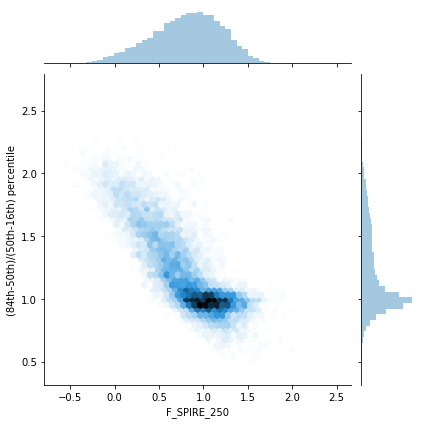

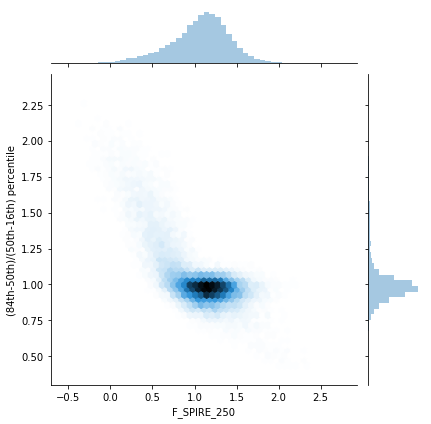

In [86]:
skew=(data_rerun_table['FErr_SPIRE_250_u']-data_rerun_table['F_SPIRE_250'])/(data_rerun_table['F_SPIRE_250']-data_rerun_table['FErr_SPIRE_250_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(data_rerun_table['F_SPIRE_250']),y=skew, kind='hex')

skew=(lofar_cat['FErr_SPIRE_250_u']-lofar_cat['F_SPIRE_250'])/(lofar_cat['F_SPIRE_250']-lofar_cat['FErr_SPIRE_250_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_cat['F_SPIRE_250']),y=skew, kind='hex')


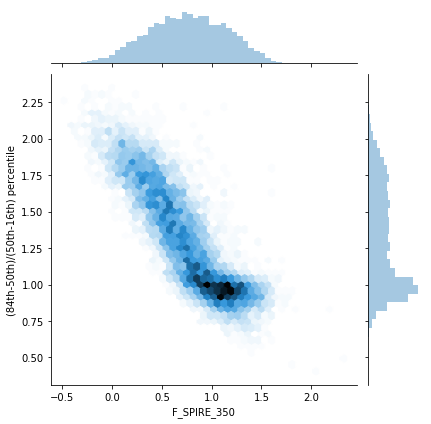

In [87]:
skew=(data_rerun_table['FErr_SPIRE_350_u']-data_rerun_table['F_SPIRE_350'])/(data_rerun_table['F_SPIRE_350']-data_rerun_table['FErr_SPIRE_350_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(data_rerun_table['F_SPIRE_350']),y=skew, kind='hex')

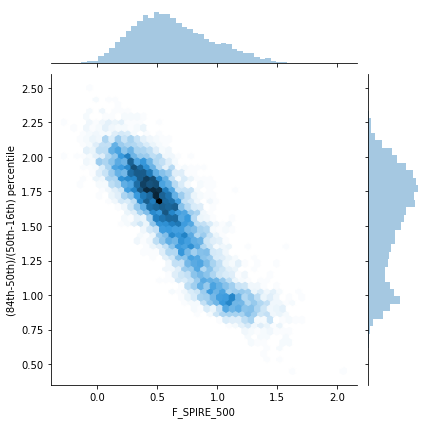

In [88]:
skew=(data_rerun_table['FErr_SPIRE_500_u']-data_rerun_table['F_SPIRE_500'])/(data_rerun_table['F_SPIRE_500']-data_rerun_table['FErr_SPIRE_500_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(data_rerun_table['F_SPIRE_500']),y=skew, kind='hex')

In [89]:
data_rerun_table.add_column(Column(np.zeros(len(data_rerun_table), dtype=bool),name='flag_spire_250'))
data_rerun_table.add_column(Column(np.zeros(len(data_rerun_table), dtype=bool),name='flag_spire_350'))
data_rerun_table.add_column(Column(np.zeros(len(data_rerun_table), dtype=bool),name='flag_spire_500'))

In [92]:
ind_SERVS_250=(data_rerun_table['Pval_res_250']>0.5) | (data_rerun_table['F_SPIRE_250'] < 10**0.7)
ind_SERVS_350=(data_rerun_table['Pval_res_350']>0.5) | (data_rerun_table['F_SPIRE_350'] < 10**0.7)
ind_SERVS_500=(data_rerun_table['Pval_res_500']>0.5) | (data_rerun_table['F_SPIRE_500'] < 10**0.9)

print(ind_SERVS_250.sum(),ind_SERVS_350.sum(),ind_SERVS_500.sum(),len(data_rerun_table))

data_rerun_table['flag_spire_250'][ind_SERVS_250]=True
data_rerun_table['flag_spire_350'][ind_SERVS_350]=True
data_rerun_table['flag_spire_500'][ind_SERVS_500]=True

3344 3991 6988 8568


In [93]:
data_rerun_table.add_column(Column(np.zeros(len(data_rerun_table), dtype=float),name='ferr_spire_250'))
data_rerun_table.add_column(Column(np.zeros(len(data_rerun_table), dtype=float),name='ferr_spire_350'))
data_rerun_table.add_column(Column(np.zeros(len(data_rerun_table), dtype=float),name='ferr_spire_500'))

In [94]:
ferr_250 = (data_rerun_table['FErr_SPIRE_250_u'] - data_rerun_table['FErr_SPIRE_250'])/2
ferr_350 = (data_rerun_table['FErr_SPIRE_350_u'] - data_rerun_table['FErr_SPIRE_350'])/2 
ferr_500 = (data_rerun_table['FErr_SPIRE_500_u'] - data_rerun_table['FErr_SPIRE_500'])/2 

KeyError: 'FErr_SPIRE_250'

In [49]:
data_rerun_table['ferr_spire_250'] = ferr_250
data_rerun_table['ferr_spire_350'] = ferr_350
data_rerun_table['ferr_spire_500'] = ferr_500

In [50]:
data_rerun_table.rename_column('RA_1','RA_radio')
data_rerun_table.rename_column('DEC','DEC_radio')
data_rerun_table.rename_column('RA_2','RA_optical')
data_rerun_table.rename_column('Dec','DEC_optical')
data_rerun_table.rename_column('F_SPIRE_250','f_spire_250')
data_rerun_table.rename_column('F_SPIRE_350','f_spire_350')
data_rerun_table.rename_column('F_SPIRE_500','f_spire_500')

In [62]:
data_rerun_table.colnames

['HELP_ID',
 'RA',
 'Dec',
 'F_SPIRE_250',
 'FErr_SPIRE_250_u',
 'FErr_SPIRE_250_l',
 'F_SPIRE_350',
 'FErr_SPIRE_350_u',
 'FErr_SPIRE_350_l',
 'F_SPIRE_500',
 'FErr_SPIRE_500_u',
 'FErr_SPIRE_500_l',
 'Bkg_SPIRE_250',
 'Bkg_SPIRE_350',
 'Bkg_SPIRE_500',
 'Sig_conf_SPIRE_250',
 'Sig_conf_SPIRE_350',
 'Sig_conf_SPIRE_500',
 'Rhat_SPIRE_250',
 'Rhat_SPIRE_350',
 'Rhat_SPIRE_500',
 'n_eff_SPIRE_250',
 'n_eff_SPIRE_500',
 'n_eff_SPIRE_350',
 'Pval_res_250',
 'Pval_res_350',
 'Pval_res_500',
 'flag_spire_250',
 'flag_spire_350',
 'flag_spire_500']

In [63]:
data_rerun_table[:5]

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool
ILTJ161304.30+544332.4,243.2676040673653,54.72568282263926,4.7087517,9.104903,1.5533694,4.2899246,9.569868,1.3658488,2.2278867,5.788372,0.5397067,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,0.99960965,0.99840236,0.99832195,3178.1377,3715.3347,3386.8203,0.869,0.949,0.814,True,True,True
ILTJ161304.30+561522.8,243.2678978128372,56.256355895233916,1.6529181,2.805987,0.73787355,3.3026998,5.0880313,1.5062444,5.9096265,10.010402,2.5227087,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,0.9998477,0.99959725,1.0023133,2034.912,2231.2812,1665.7777,0.825,0.986,0.999,True,True,True
ILTJ161304.33+550113.0,243.2678785054324,55.02040368403693,2.3265188,5.8106585,0.5759385,4.416595,10.319738,1.1393299,2.8116398,6.6855893,0.7310601,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,1.0001607,0.99840456,0.99995065,3515.9016,3090.7202,3141.0396,0.464,0.992,0.978,True,True,True
ILTJ161304.75+532645.2,243.27002610676323,53.44605074607362,24.110489,27.980282,20.462427,15.938558,19.780361,12.182269,9.237537,16.477966,3.2797263,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,0.9985059,1.0001668,1.0001134,3666.7322,2608.0515,2901.8083,0.874,0.929,0.876,True,True,True
ILTJ161304.76+554704.9,243.26987976290073,55.78481478797746,5.0550447,7.2182813,2.9331796,8.396453,12.349156,4.3556056,4.734474,9.326737,1.4084663,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,1.000078,1.001477,0.99911934,2288.5608,2468.7651,1929.7289,0.009,0.996,0.99,False,True,True


In [19]:
data_rerun_table.rename_column('HELP_ID','Source_Name')

In [21]:
rerun_col = Column(np.ones(len(data_rerun_table)),name='XID+_rerun',dtype='bool')
data_rerun_table.add_column(rerun_col)

In [322]:
data_rerun_table[:5]

Source_Name,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,XID+_rerun
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool
ILTJ161304.30+544332.4,243.2676040673653,54.72568282263926,4.7087517,9.104903,1.5533694,4.2899246,9.569868,1.3658488,2.2278867,5.788372,0.5397067,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,0.99960965,0.99840236,0.99832195,3178.1377,3715.3347,3386.8203,0.869,0.949,0.814,True
ILTJ161304.30+561522.8,243.2678978128372,56.256355895233916,1.6529181,2.805987,0.73787355,3.3026998,5.0880313,1.5062444,5.9096265,10.010402,2.5227087,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,0.9998477,0.99959725,1.0023133,2034.912,2231.2812,1665.7777,0.825,0.986,0.999,True
ILTJ161304.33+550113.0,243.2678785054324,55.02040368403693,2.3265188,5.8106585,0.5759385,4.416595,10.319738,1.1393299,2.8116398,6.6855893,0.7310601,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,1.0001607,0.99840456,0.99995065,3515.9016,3090.7202,3141.0396,0.464,0.992,0.978,True
ILTJ161304.75+532645.2,243.27002610676323,53.44605074607362,24.110489,27.980282,20.462427,15.938558,19.780361,12.182269,9.237537,16.477966,3.2797263,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,0.9985059,1.0001668,1.0001134,3666.7322,2608.0515,2901.8083,0.874,0.929,0.876,True
ILTJ161304.76+554704.9,243.26987976290073,55.78481478797746,5.0550447,7.2182813,2.9331796,8.396453,12.349156,4.3556056,4.734474,9.326737,1.4084663,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,1.000078,1.001477,0.99911934,2288.5608,2468.7651,1929.7289,0.009,0.996,0.99,True


In [75]:
Table.write(data_rerun_table,'data/fir_v2/XID+_lofar_ELAIS-N1.fits')

### Running checks on the FIR fluxes to see how they compare with the crossmatched fluxes already in the LOFAR catalogue

In [16]:
lofar_cat = Table.read('data/data_release/final_cross_match_catalogue-v0.1.fits')

In [17]:
lofar_cat[0]

Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,FLAG_WORKFLOW,Prefilter,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,FLAG_OVERLAP,Separation,help_id,RA_HELP,DEC_HELP,EBV,Z_SPEC,CLASS_STAR,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,AGN,optAGN,IRAGN,XrayAGN,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,hp_idx_11,hp_depth_cluster
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,bytes27,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bool,bool,bool,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,bytes6,int64,int32
ILTJ155957.58+550052.4,239.98990167026162,55.01456045936245,5.366954914924915e-05,8.08706707123675e-05,0.0003958345213565919,5.4160526835678236e-05,0.0003247963953282784,2.715224507873135e-05,S,0.002071920400992901,0.0016345290335764496,166.30848152559156,0.00019279093100176814,0.00012276320016402095,13.835288085283342,0.0,0.0,0.0,1,0,329.1186755105229,239.98983453474398,55.01474018731156,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,Create initial sources,LR,,7,1,1018637,73464.984,38011.69,239.98983453474398,55.01474018731156,1,1180605,--,7

In [22]:
lofar_xid_join = join(lofar_cat,data_rerun_table,join_type='outer',keys='Source_Name')
lofar_xid_join['XID+_rerun'] = ~lofar_xid_join['XID+_rerun'].mask

In [337]:
lofar_xid_join[:5]

Source_Name,RA_1,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,FLAG_WORKFLOW,Prefilter,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,FLAG_OVERLAP,Separation,help_id,RA_HELP,DEC_HELP,EBV,Z_SPEC,CLASS_STAR,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250_1,FErr_SPIRE_250_u_1,FErr_SPIRE_250_l_1,F_SPIRE_350_1,FErr_SPIRE_350_u_1,FErr_SPIRE_350_l_1,F_SPIRE_500_1,FErr_SPIRE_500_u_1,FErr_SPIRE_500_l_1,Bkg_SPIRE_250_1,Bkg_SPIRE_350_1,Bkg_SPIRE_500_1,Sig_conf_SPIRE_250_1,Sig_conf_SPIRE_350_1,Sig_conf_SPIRE_500_1,Rhat_SPIRE_250_1,Rhat_SPIRE_350_1,Rhat_SPIRE_500_1,n_eff_SPIRE_250_1,n_eff_SPIRE_500_1,n_eff_SPIRE_350_1,Pval_res_250_1,Pval_res_350_1,Pval_res_500_1,flag_spire_250,flag_spire_350,flag_spire_500,AGN,optAGN,IRAGN,XrayAGN,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,hp_idx_11,hp_depth_cluster,RA_2,Dec,F_SPIRE_250_2,FErr_SPIRE_250_u_2,FErr_SPIRE_250_l_2,F_SPIRE_350_2,FErr_SPIRE_350_u_2,FErr_SPIRE_350_l_2,F_SPIRE_500_2,FErr_SPIRE_500_u_2,FErr_SPIRE_500_l_2,Bkg_SPIRE_250_2,Bkg_SPIRE_350_2,Bkg_SPIRE_500_2,Sig_conf_SPIRE_250_2,Sig_conf_SPIRE_350_2,Sig_conf_SPIRE_500_2,Rhat_SPIRE_250_2,Rhat_SPIRE_350_2,Rhat_SPIRE_500_2,n_eff_SPIRE_250_2,n_eff_SPIRE_500_2,n_eff_SPIRE_350_2,Pval_res_250_2,Pval_res_350_2,Pval_res_500_2,XID+_rerun
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,
bytes27,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,bytes27,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bool,bool,bool,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float

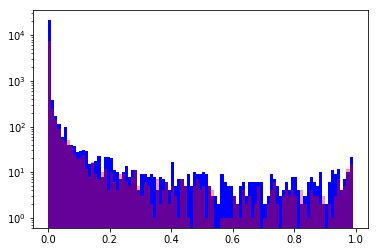

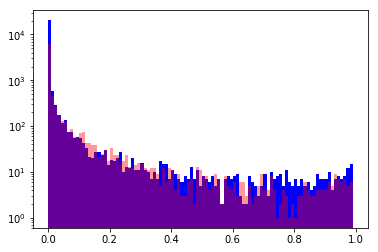

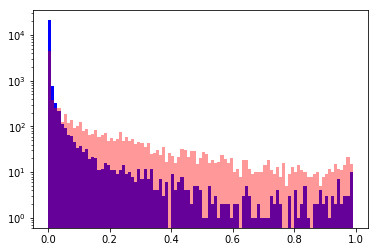

In [73]:
bins = np.arange(0,1,0.01)
dat = lofar_cat['Pval_res_250']
plt.hist(dat,bins=bins,log=True,color='blue')

dat = data_rerun_table['Pval_res_250']
plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)

plt.show()

dat = lofar_cat['Pval_res_350']
plt.hist(dat,bins=bins,log=True,color='blue')

dat = data_rerun_table['Pval_res_350']
plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)

plt.show()

dat = lofar_cat['Pval_res_500']
plt.hist(dat,bins=bins,log=True,color='blue')

dat = data_rerun_table['Pval_res_500']
plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)

plt.show()

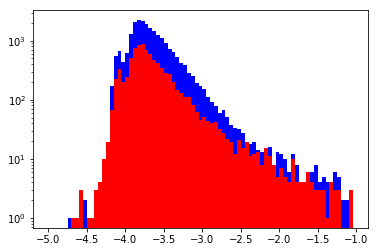

In [88]:
mask = ~np.isnan(lofar_cat['F_SPIRE_250'])
bins = np.arange(-5,-1,0.05)
dat = np.log10(lofar_cat['Peak_flux'][mask])
plt.hist(dat,bins=bins,log=True,color='blue')

dat = np.log10(lofar_cat['Peak_flux'][~mask])
plt.hist(dat,bins=bins,log=True,color='red')
plt.show()

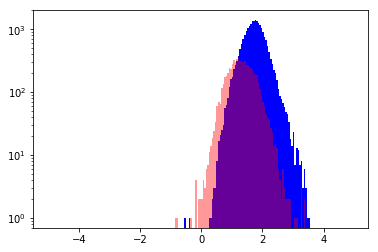

In [92]:
mask = ~np.isnan(lofar_cat['F_SPIRE_250'])
bins = np.arange(-5,5,0.05)
dat = np.log10(lofar_cat['ch1_swire_flux'][mask])
plt.hist(dat,bins=bins,log=True,color='blue')

dat = np.log10(lofar_cat['ch1_swire_flux'][~mask])
plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)
plt.show()

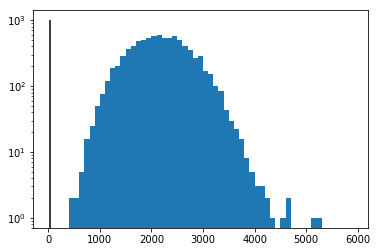

In [98]:
bins = np.arange(0,6000,100)
dat = data_rerun_table['n_eff_SPIRE_250']
plt.hist(dat,bins=bins,log=True)
plt.vlines(40,0,1000)
plt.show()

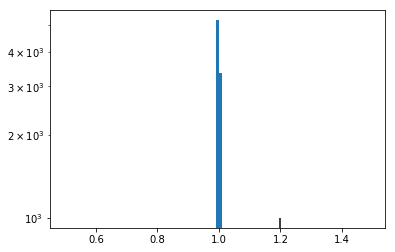

In [101]:
bins = np.arange(0.5,1.5,0.01)
dat = data_rerun_table['Rhat_SPIRE_250']
plt.hist(dat,bins=bins,log=True)
plt.vlines(1.2,0,1000)
plt.show()

In [328]:
len(lofar_xid_join)

31748

23179
8569


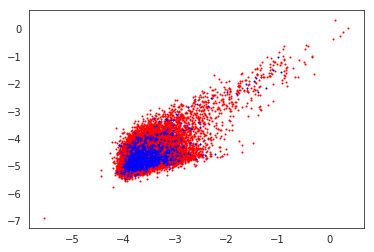

In [342]:
mask = lofar_xid_join['XID+_rerun']
bins = np.arange(0,5,0.1)

#plt.hist(dat,bins=bins,log=True,color='blue')
dist = cosmo.luminosity_distance(dat).to(u.m).value
rad = np.log10(lofar_xid_join['Total_flux'][~mask])
fir = np.log10(lofar_xid_join['F_SPIRE_250_1'][~mask])
y = rad-fir
print(len(y))
plt.scatter(rad,y,s=1,c='red')


#plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)
rad = np.log10(lofar_xid_join['Total_flux'][mask])
fir = np.log10(lofar_xid_join['F_SPIRE_250_1'][mask])
y = rad-fir
print(len(y))
plt.scatter(rad,y,s=1,c='blue')
plt.show()

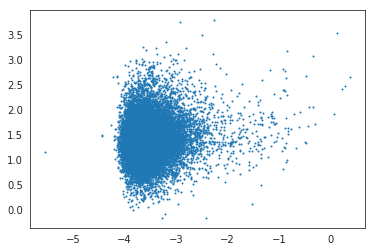

In [349]:
mask = ~lofar_xid_join['XID+_rerun']
x = np.log10(lofar_xid_join['Total_flux'][mask])
y = np.log10(lofar_xid_join['F_MIPS_24'][mask]/lofar_xid_join['F_SPIRE_250_1'][mask])
plt.scatter(x,y,s=1)
plt.show()

26328
6500


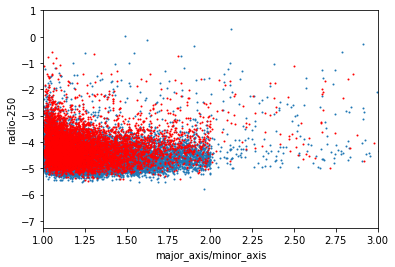

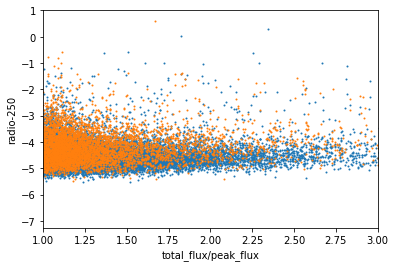

In [74]:
mask = ~lofar_xid_join['XID+_rerun']
x = lofar_xid_join['Maj'][mask]/lofar_xid_join['Min'][mask]
print(len(x))
y = np.log10(lofar_xid_join['Total_flux'][mask]/lofar_xid_join['F_SPIRE_250_1'][mask])
plt.scatter(x,y,s=1)

mask = lofar_xid_join['XID+_rerun']
x = lofar_xid_join['Maj'][mask]/lofar_xid_join['Min'][mask]
print(len(x))
y = np.log10(lofar_xid_join['Total_flux'][mask]/lofar_xid_join['F_SPIRE_250_2'][mask])
plt.scatter(x,y,s=1,c='red')

plt.xlim(1,3)
plt.xlabel('major_axis/minor_axis')
plt.ylabel('radio-250')
plt.show()

mask = ~lofar_xid_join['XID+_rerun']
x = lofar_xid_join['Total_flux'][mask]/lofar_xid_join['Peak_flux'][mask]
y = np.log10(lofar_xid_join['Total_flux'][mask]/lofar_xid_join['F_SPIRE_250_1'][mask])
plt.scatter(x,y,s=1)

mask = lofar_xid_join['XID+_rerun']
x = lofar_xid_join['Total_flux'][mask]/lofar_xid_join['Peak_flux'][mask]
y = np.log10(lofar_xid_join['Total_flux'][mask]/lofar_xid_join['F_SPIRE_250_2'][mask])
plt.scatter(x,y,s=1)

plt.xlim(1,3)
plt.xlabel('total_flux/peak_flux')
plt.ylabel('radio-250')
plt.show()

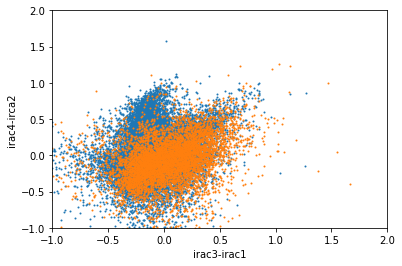

In [75]:
mask = ~np.isnan(lofar_cat['F_SPIRE_250']) #& (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
c1 = np.log10(lofar_cat['ch3_swire_flux'][mask]/lofar_cat['ch1_swire_flux'][mask])
c2 = np.log10(lofar_cat['ch4_swire_flux'][mask]/lofar_cat['ch2_swire_flux'][mask])
plt.scatter(c1,c2,s=1)

mask = np.isnan(lofar_cat['F_SPIRE_250']) #& (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
c1 = np.log10(lofar_cat['ch3_swire_flux'][mask]/lofar_cat['ch1_swire_flux'][mask])
c2 = np.log10(lofar_cat['ch4_swire_flux'][mask]/lofar_cat['ch2_swire_flux'][mask])
z_col = lofar_cat['z1_median'][mask]
z_bins = np.arange(0,4,0.5)
z_binned = np.digitize(z_col,z_bins)
#plt.scatter(c1[0],c2[0],s=100,c='red')
plt.scatter(c1,c2,s=1)
#plt.scatter(c1[0],c2[0],s=10,c='red')
#plt.scatter(c1[0],c2[0],s=1,c=z_binned[0])


plt.xlim(-1,2)
plt.ylim(-1,2)
plt.xlabel('irac3-irac1')
plt.ylabel('irac4-irca2')
#plt.title('{} < z < {}'.format(z_bins[n],z_bins[n+1]))
plt.show()

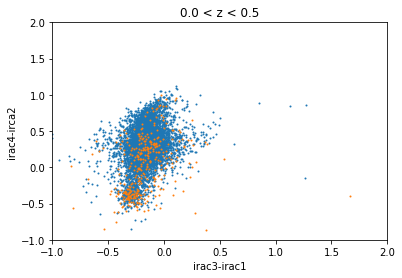

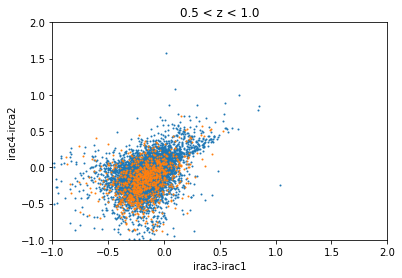

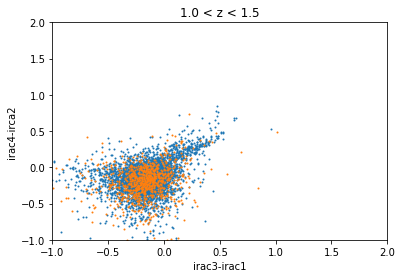

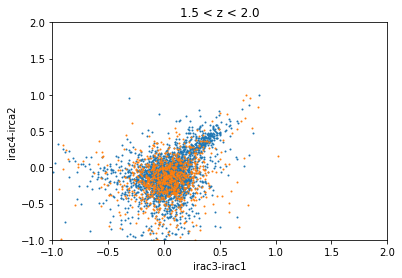

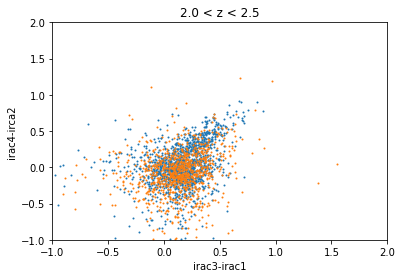

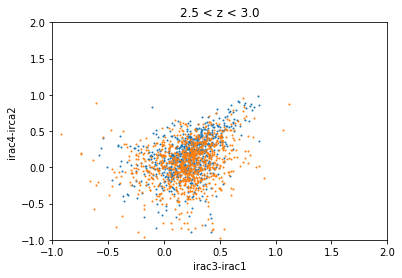

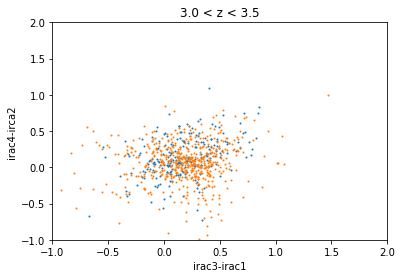

In [76]:
z_bins = np.arange(0,4,0.5)
dist = cosmo.luminosity_distance(lofar_cat['z1_median']).to(u.m).value
ch1_lum = lofar_cat['ch1_swire_flux']*4*np.pi*dist**2
ch2_lum = lofar_cat['ch2_swire_flux']*4*np.pi*dist**2
ch3_lum = lofar_cat['ch3_swire_flux']*4*np.pi*dist**2
ch4_lum = lofar_cat['ch4_swire_flux']*4*np.pi*dist**2
for n in range(len(z_bins)-1):
    mask = ~np.isnan(lofar_cat['F_SPIRE_250']) & (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
    c1 = np.log10(lofar_cat['ch3_swire_flux'][mask]/lofar_cat['ch1_swire_flux'][mask])
    c2 = np.log10(lofar_cat['ch4_swire_flux'][mask]/lofar_cat['ch2_swire_flux'][mask])
    plt.scatter(c1,c2,s=1)

    mask = np.isnan(lofar_cat['F_SPIRE_250']) & (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
    c1 = np.log10(lofar_cat['ch3_swire_flux'][mask]/lofar_cat['ch1_swire_flux'][mask])
    c2 = np.log10(lofar_cat['ch4_swire_flux'][mask]/lofar_cat['ch2_swire_flux'][mask])
    z_col = lofar_cat['z1_median'][mask]
    z_bins = np.arange(0,4,0.5)
    z_binned = np.digitize(z_col,z_bins)
#plt.scatter(c1[0],c2[0],s=100,c='red')
    plt.scatter(c1,c2,s=1)
#plt.scatter(c1[0],c2[0],s=10,c='red')
#plt.scatter(c1[0],c2[0],s=1,c=z_binned[0])


    plt.xlim(-1,2)
    plt.ylim(-1,2)
    plt.xlabel('irac3-irac1')
    plt.ylabel('irac4-irca2')
    plt.title('{} < z < {}'.format(z_bins[n],z_bins[n+1]))
    plt.show()

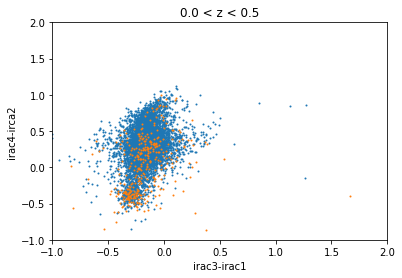

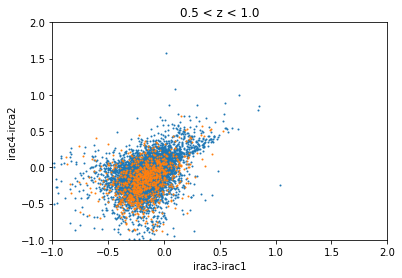

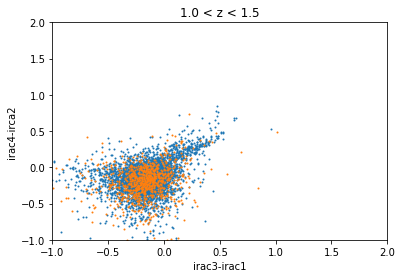

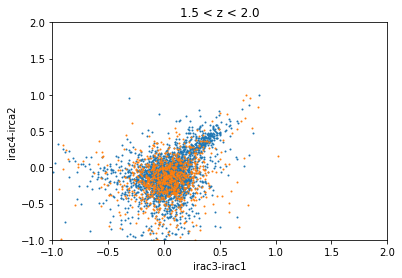

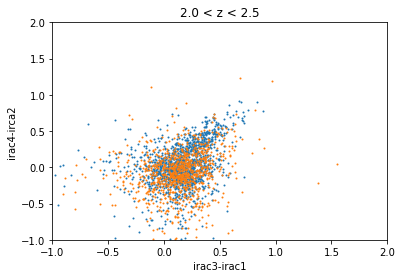

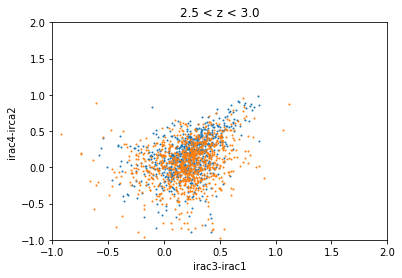

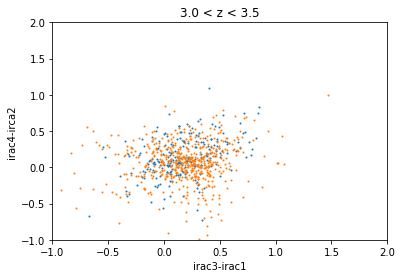

In [31]:
z_bins = np.arange(0,4,0.5)
dist = cosmo.luminosity_distance(lofar_cat['z1_median']).to(u.m).value
ch1_lum = lofar_cat['ch1_swire_flux']*4*np.pi*dist**2
ch2_lum = lofar_cat['ch2_swire_flux']*4*np.pi*dist**2
ch3_lum = lofar_cat['ch3_swire_flux']*4*np.pi*dist**2
ch4_lum = lofar_cat['ch4_swire_flux']*4*np.pi*dist**2
for n in range(len(z_bins)-1):
    mask = ~np.isnan(lofar_cat['F_SPIRE_250']) & (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
    c1 = np.log10(ch3_lum[mask]/ch1_lum[mask])
    c2 = np.log10(ch4_lum[mask]/ch2_lum[mask])
    plt.scatter(c1,c2,s=1)

    mask = np.isnan(lofar_cat['F_SPIRE_250']) & (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
    c1 = np.log10(ch3_lum[mask]/ch1_lum[mask])
    c2 = np.log10(ch4_lum[mask]/ch2_lum[mask])
    z_col = lofar_cat['z1_median'][mask]
    z_bins = np.arange(0,4,0.5)
    z_binned = np.digitize(z_col,z_bins)
#plt.scatter(c1[0],c2[0],s=100,c='red')
    plt.scatter(c1,c2,s=1)
#plt.scatter(c1[0],c2[0],s=10,c='red')
#plt.scatter(c1[0],c2[0],s=1,c=z_binned[0])


    plt.xlim(-1,2)
    plt.ylim(-1,2)
    plt.xlabel('irac3-irac1')
    plt.ylabel('irac4-irca2')
    plt.title('{} < z < {}'.format(z_bins[n],z_bins[n+1]))
    plt.show()

In [142]:
z_binned

array([3, 8, 4, ..., 5, 8, 8])

In [143]:
lofar_cat['z1_median'][~mask][0]

1.4289

In [183]:
priors,posteriors = xidplus.load('data/fir_v2/xidplus_run_0/lofar_xidplus_fir_0_rerun.pkl.pkl')

In [161]:
'ILTJ160008.18+545132.1' in priors[0].ID

True

In [119]:

def ymod_map(prior,flux):
    """Create replicated model map (no noise or background) i.e. A*f

    :param prior: xidplus.prior class
    :param flux: flux vector
    :return: map array, in same format as prior.sim
    """
    from scipy.sparse import coo_matrix

    f=coo_matrix((flux, (range(0,prior.nsrc),np.zeros(prior.nsrc))), shape=(prior.nsrc, 1))
    A=coo_matrix((prior.amat_data, (prior.amat_row, prior.amat_col)), shape=(prior.snpix, prior.nsrc))
    rmap_temp=(A*f)
    return np.asarray(rmap_temp.todense())

def replicated_maps(priors,posterior,nrep=1000):
    """Create posterior replicated maps

    :param priors: list of xidplus.prior class
    :param posterior: xidplus.posterior class
    :param nrep: number of replicated maps
    :return: 
    """
    mod_map_array=list(map(lambda prior:np.empty((prior.snpix,nrep)), priors))
    for i in range(0,nrep):
        try:
            for b in range(0,len(priors)):
                mod_map_array[b][:,i]= ymod_map(priors[b],posterior.samples['src_f'][i,b,:]).reshape(-1)\
                                       +posterior.samples['bkg'][i,b]\
                                       +np.random.normal(scale=np.sqrt(priors[b].snim**2
                                                                       +posterior.samples['sigma_conf'][i,b]**2))
        except IndexError:
            for b in range(0,len(priors)):
                mod_map_array[b][:,i]= ymod_map(priors[b],posterior.samples['src_f'][i,b,:]).reshape(-1)\
                                       +posterior.samples['bkg'][i]\
                                       +np.random.normal(scale=np.sqrt(priors[b].snim**2
                                                                       +posterior.samples['sigma_conf'][i]**2))
    return mod_map_array

In [120]:
def Bayes_Pval_res(prior,post_rep_map):
    """The local Bayesian P value residual statistic. 
    
    
    :param prior: xidplus.prior class
    :param post_rep_map: posterior replicated maps
    :return: Bayesian P value residual statistic for each source
    """
    Bayes_pval_res_vals=np.empty((prior.nsrc))
    for i in range(0,prior.nsrc):
        ind= prior.amat_col == i
        t = np.sum(((post_rep_map[prior.amat_row[ind], :] - prior.sim[prior.amat_row[ind], None]) / (
        np.sqrt(2) * prior.snim[prior.amat_row[ind], None])) ** 2.0, axis=0)
        ind_T = t / ind.sum() > 2
        Bayes_pval_res_vals[i] = ind_T.sum()/np.float(post_rep_map.shape[1])

    return Bayes_pval_res_vals

In [ ]:
def plot_Bayes_pval_map_pos(priors, posterior,pos):

    """

    :param priors: list of xidplus.prior classes
    :param posterior: xidplus.posterior class
    :return: the default xidplus Bayesian P value map plot
    """
    ra,dec = pos
    sns.set_style("white")
    mod_map_array = postmaps.replicated_maps(priors, posterior, posterior.samples['lp__'].size)
    Bayes_pvals = []

    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
    fig = plt.figure(figsize=(10 * len(priors), 10))
    figs = []
    for i in range(0, len(priors)):
        figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(1, len(priors), i + 1)))
        Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array[i]))

    for i in range(0, len(priors)):
        figs[i].show_markers(priors[i].sra, priors[i].sdec, edgecolor='black', facecolor='black',
                             marker='o', s=20, alpha=0.5)
        figs[i].tick_labels.set_xformat('dd.dd')
        figs[i].tick_labels.set_yformat('dd.dd')
        figs[i]._data[
            priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
        Bayes_pvals[i]
        figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
        figs[i].add_colorbar()
        figs[i].colorbar.set_location('top')
    return figs, fig

In [121]:
rep_maps = replicated_maps(priors,posteriors)

In [122]:
Bayes_Pval_res(priors[0],rep_maps[0])

array([0.478, 0.028, 0.148, 0.013, 0.002, 0.114, 0.984, 0.002, 0.004,
       0.001, 0.472, 0.874, 0.915, 0.995, 0.026, 0.99 , 0.634, 0.872,
       0.965, 0.972, 0.055, 0.905, 0.991, 0.801, 0.941, 0.99 , 0.445,
       0.991, 0.394, 0.478, 0.441, 0.854, 0.893, 0.712, 0.934, 0.993,
       0.318, 0.98 , 0.003, 0.931, 0.119, 0.95 , 0.788, 0.925, 0.826,
       0.417, 0.94 , 0.992, 0.057, 0.952, 0.945, 0.915, 0.55 , 0.71 ,
       0.478, 0.936, 0.743, 0.941, 0.298, 0.934, 0.236, 0.966, 0.563,
       0.761, 0.621, 0.007, 0.804, 0.297, 0.944, 0.134, 0.684, 0.434,
       0.03 , 0.859, 0.335, 0.651, 0.004, 0.253, 0.008, 0.166, 0.856,
       0.273, 0.   , 0.857, 0.564, 0.407, 0.581, 0.602, 0.763, 0.984,
       0.142, 0.206, 0.731, 0.379, 0.45 , 0.87 , 0.091, 0.443, 0.12 ,
       0.478, 0.725, 0.127, 0.159, 0.124, 0.614, 0.46 , 0.112, 0.   ,
       0.557, 0.945, 0.678, 0.259, 0.379, 0.845, 0.323, 0.354, 0.437,
       0.166, 0.161, 0.711, 0.122, 0.798, 0.767, 0.133, 0.735, 0.721,
       0.024, 0.018,

In [124]:
len(priors[0].amat_col)

10998

In [190]:
data_rerun_table[:5]

Source_Name,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,XID+_rerun
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,bool
ILTJ161304.30+544332.4,243.2676040673653,54.72568282263926,4.7087517,9.104903,1.5533694,4.2899246,9.569868,1.3658488,2.2278867,5.788372,0.5397067,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,0.99960965,0.99840236,0.99832195,3178.1377,3715.3347,3386.8203,0.869,0.949,0.814,True,True,True,True
ILTJ161304.30+561522.8,243.2678978128372,56.256355895233916,1.6529181,2.805987,0.73787355,3.3026998,5.0880313,1.5062444,5.9096265,10.010402,2.5227087,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,0.9998477,0.99959725,1.0023133,2034.912,2231.2812,1665.7777,0.825,0.986,0.999,True,True,True,True
ILTJ161304.33+550113.0,243.2678785054324,55.02040368403693,2.3265188,5.8106585,0.5759385,4.416595,10.319738,1.1393299,2.8116398,6.6855893,0.7310601,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,1.0001607,0.99840456,0.99995065,3515.9016,3090.7202,3141.0396,0.464,0.992,0.978,True,True,True,True
ILTJ161304.75+532645.2,243.27002610676323,53.44605074607362,24.110489,27.980282,20.462427,15.938558,19.780361,12.182269,9.237537,16.477966,3.2797263,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,0.9985059,1.0001668,1.0001134,3666.7322,2608.0515,2901.8083,0.874,0.929,0.876,True,True,True,True
ILTJ161304.76+554704.9,243.26987976290073,55.78481478797746,5.0550447,7.2182813,2.9331796,8.396453,12.349156,4.3556056,4.734474,9.326737,1.4084663,-1.8906862,-4.6683464,-12.256412,0.9326457,1.4793754,2.2639425,1.000078,1.001477,0.99911934,2288.5608,2468.7651,1929.7289,0.009,0.996,0.99,False,True,True,True


In [229]:
skew=(data_rerun_table['FErr_SPIRE_250_u']-data_rerun_table['F_SPIRE_250'])/(data_rerun_table['F_SPIRE_250']-data_rerun_table['FErr_SPIRE_250_l'])

indeces = [index for index,s in enumerate(skew) if ((s>1.5) and (data_rerun_table['F_SPIRE_250'][index]>8))]

runs = find_posteror_source(indeces,data_rerun_table['Source_Name'][indeces])

8
data/fir_v2/xidplus_run_567/lofar_xidplus_fir_567_rerun.pkl.pkl
ILTJ161339.06+544757.0
12
data/fir_v2/xidplus_run_384/lofar_xidplus_fir_384_rerun.pkl.pkl
ILTJ161019.79+534659.9
65
data/fir_v2/xidplus_run_676/lofar_xidplus_fir_676_rerun.pkl.pkl
ILTJ161547.86+535412.4
81
data/fir_v2/xidplus_run_479/lofar_xidplus_fir_479_rerun.pkl.pkl
ILTJ161200.31+544213.3
105
data/fir_v2/xidplus_run_293/lofar_xidplus_fir_293_rerun.pkl.pkl
ILTJ160843.70+533832.2
177
data/fir_v2/xidplus_run_779/lofar_xidplus_fir_779_rerun.pkl.pkl
ILTJ161835.16+541908.4
198
data/fir_v2/xidplus_run_9/lofar_xidplus_fir_9_rerun.pkl.pkl
ILTJ160044.68+550549.4
source number :1989: not in opened file. Something is wrong
234
data/fir_v2/xidplus_run_478/lofar_xidplus_fir_478_rerun.pkl.pkl
ILTJ161158.59+555753.8
267
data/fir_v2/xidplus_run_408/lofar_xidplus_fir_408_rerun.pkl.pkl
ILTJ161041.29+550705.9
313
data/fir_v2/xidplus_run_319/lofar_xidplus_fir_319_rerun.pkl.pkl
ILTJ160910.21+552503.9
321
data/fir_v2/xidplus_run_403/lofar_x

In [255]:
pkl_list = glob.glob('data/fir_v2/*/*.pkl')

for i,file in enumerate(pkl_list):
    if i%5==0:
        print(i)
    priors,posterior = xidplus.load(file)
    rep_maps = xidplus.posterior_maps.replicated_maps(priors,posterior)
    
    for n,prior in enumerate(priors):
        pval = xidplus.posterior_maps.make_Bayesian_pval_maps(prior,rep_maps[n])
        pval_map = xidplus.posterior_maps.make_fits_image(prior,pval)
        pval_map.writeto(file.replace('pkl.pkl','fits').replace('lofar_xidplus_fir','lofar_xidplus_pval_map'),overwrite=True)

0
5
10
15
20
25
30
35
40
45
50
55
60
65


KeyboardInterrupt: 

In [256]:
np.zeros(5)*np.nan

array([nan, nan, nan, nan, nan])

([<aplpy.core.FITSFigure at 0x7fff8323ef98>,
 <Figure size 2160x720 with 6 Axes>)

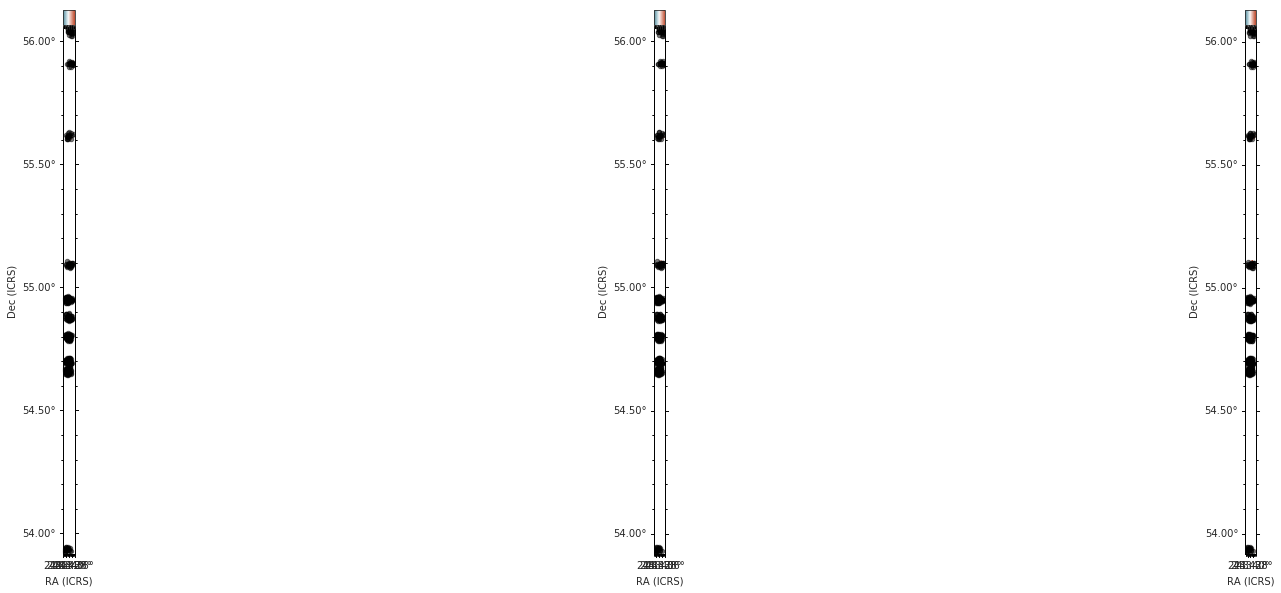

In [232]:
xidplus.plots.plot_Bayes_pval_map(runs[0][0],runs[0][1])

In [244]:
test = xidplus.posterior_maps.make_Bayesian_pval_maps(priors[0],replicated_maps(priors,posteriors)[0])

In [246]:
test.shape

(2576,)